In [1]:
# ! pip install torchdiffeq einops jetnet pytorch-lightning

In [2]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import models.stribor_lib as st
import torch
import numpy as np
from tqdm.notebook import tqdm

In [4]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Set flow models for jets

In [5]:
device = 'cuda'  # ['cuda', 'cpu', or 'mps']

## Define set flow model

Load model from https://arxiv.org/abs/2010.03242

In [6]:
def get_exact_model(dim, hidden_dims, latent_dim, context_dim=0, n_transforms=4, n_heads=2, model="deepset", set_data=False, device='mps', atol=1e-4, base_dist_mean=None, base_dist_cov=None):
    
    has_latent = True if context_dim > 0 else False
    
    transforms = []
    
    for _ in range(n_transforms):
        
        if model == "deepset":
            net=st.net.DiffeqExactTraceDeepSet(dim, hidden_dims, dim, d_h=latent_dim, latent_dim=context_dim)
        elif model == "settransformer":
            net=st.net.DiffeqExactTraceAttention(dim, hidden_dims, dim, d_h=latent_dim, n_heads=n_heads, latent_dim=context_dim)
        else:
            raise NotImplementedError
            
        transforms.append(st.ContinuousNormalizingFlow(dim, net=net, divergence='exact', solver='dopri5', atol=atol, has_latent=has_latent, set_data=set_data))
        
    if base_dist_mean is None:
        base_dist_mean = torch.zeros(dim)
        
    if base_dist_cov is None:
        base_dist_cov = torch.ones(dim)

    model = st.Flow(st.Normal(base_dist_mean.to(device), base_dist_cov.to(device)), transforms).to(device)
    
    return model

## Jets

In [11]:
from jetnet.datasets import JetNet, TopTagging

particle_data, jet_data = JetNet.getData(jet_type=["q"], data_dir="../data/", num_particles=150)

In [12]:
q_jets_rearranged = particle_data

In [13]:
x = torch.Tensor(q_jets_rearranged[:, :, :3])
mask = torch.Tensor(q_jets_rearranged[:, :, 3:])

mask[mask > 0] = 1
mask[mask < 0] = 0

# Change base distribution of flow according to dataset

x_mean = torch.zeros(3)
x_cov = torch.zeros(3)

for i in range(x.shape[-1]):
    x_mean[i] =  x[:, :, i].unsqueeze(-1)[mask.bool()].mean()
    x_cov[i] =  x[:, :, i].unsqueeze(-1)[mask.bool()].std()
    if i == 2:
        x_cov *= 5.

## Torch-Lightning

In [14]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

from torch.utils.data import TensorDataset, DataLoader, random_split

In [20]:
max_epochs = 30

In [21]:
class SetFlow(pl.LightningModule):

    def __init__(self, optimizer=torch.optim.AdamW, 
                         optimizer_kwargs={"weight_decay":1e-5}, 
                         lr=8e-4, 
                         scheduler=torch.optim.lr_scheduler.CosineAnnealingLR,
                         scheduler_kwargs = {"T_max":max_epochs}):
        super().__init__()
        
        self.optimizer = optimizer
        self.optimizer_kwargs = optimizer_kwargs
        self.scheduler = scheduler
        self.scheduler_kwargs = scheduler_kwargs
        self.lr = lr
        
        self.network = get_exact_model(dim=3, hidden_dims=[64, 64], latent_dim=8, context_dim=0, 
                                       n_transforms=2, n_heads=2, model="deepset", set_data=True, 
                                       base_dist_mean=x_mean,
                                       base_dist_cov=x_cov, device=device, atol=1e-4)
        
    def loss(self, x, mask):
        log_prob = self.network.log_prob(x, mask=mask) 
        loss = -(log_prob * mask).sum() / mask.sum()
        return loss
        
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        
        return {"optimizer": optimizer, 
                    "lr_scheduler": {
                    "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
            
    def training_step(self, batch, batch_idx):
        x, mask = batch
        loss = self.loss(x, mask)     
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, mask = batch
        loss = self.loss(x, mask)     
        self.log('val_loss', loss, on_epoch=True)
        return loss

In [22]:
batch_size = 256

val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, mask)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False)

In [23]:
model = SetFlow()

In [24]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", every_n_epochs=4, save_top_k=1)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=6)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Instantiate trainer
trainer = pl.Trainer(max_epochs=max_epochs, accelerator='gpu', devices=-1, gradient_clip_val=1., callbacks=[checkpoint_callback, lr_monitor, early_stop_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | Flow | 31.8 K
---------------------------------
31.8 K    Trainable params
0         Non-trainable params
31.8 K    Total params
0.127     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [25]:
# Get cardinality distribution from training data
unique, counts = np.unique((mask[:, :, -1].sum(-1)).cpu(), return_counts=True)  

In [26]:
model.eval();

In [27]:
model.to('cuda');

  0%|          | 0/16 [00:00<?, ?it/s]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


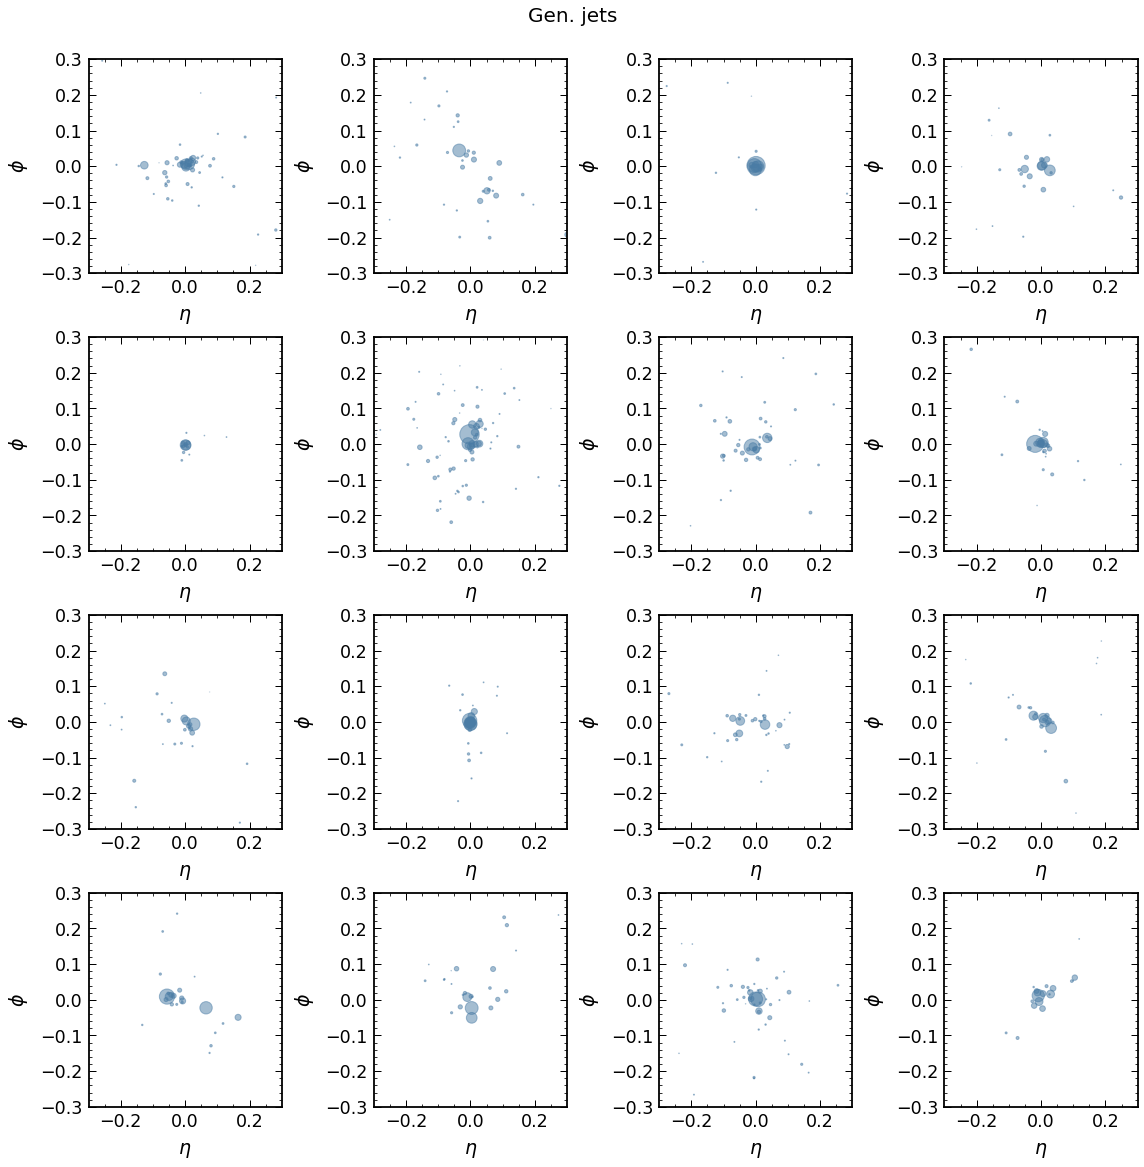

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    n_particles = int(np.random.choice(unique, p=counts / np.sum(counts)))
    
    x_sample = np.array((model.network.sample(num_samples=(n_particles)).to('cpu').detach()))
    
    ax.scatter(*x_sample[:, :2].T, s=1000 * np.abs(x_sample[:, 2]), alpha=0.5, color=cols_default[1])  # Hacky np.abs!!
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

# plt.savefig("plots/gen_jets.png", bbox_inches='tight')
# plt.tight_layout()

  0%|          | 0/16 [00:00<?, ?it/s]

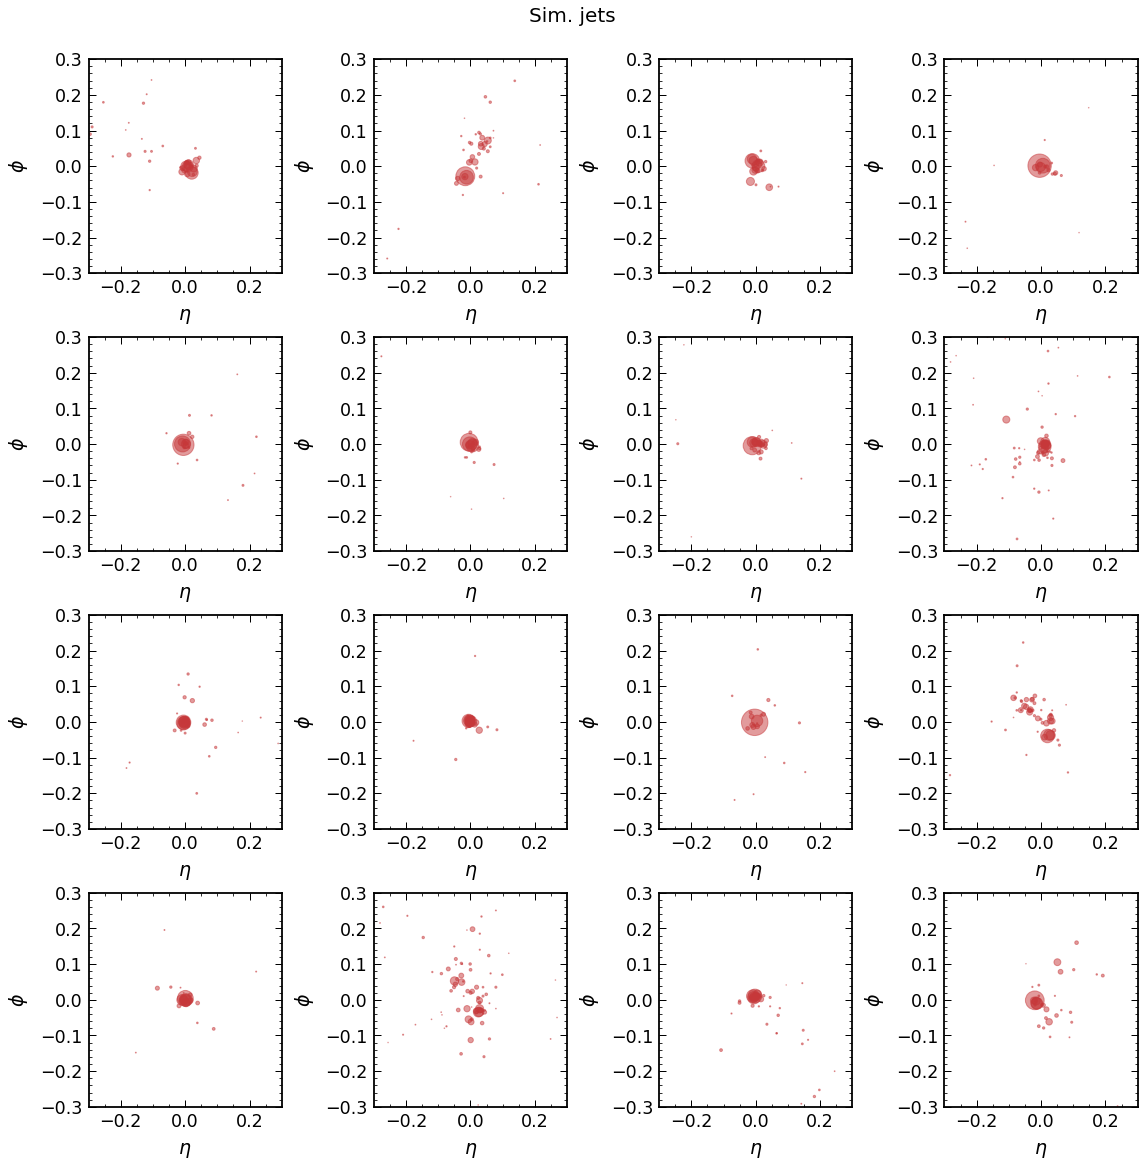

In [29]:
from scipy.special import logit

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
    
    idx = np.random.randint(len(x))
    x_plot = (x[idx, :, :2].cpu())
    s_plot = (np.abs(x[idx, :, 2].cpu()))
    s_plot[mask[idx, :, 0].cpu() < 0.] = 0.

    ax.scatter(*x_plot.T, s=1000 * s_plot, color=cols_default[0], alpha=0.5)
        
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets", fontsize=20, y=1.01)
plt.tight_layout()

# plt.savefig("plots/sim_jets.png", bbox_inches='tight')
# plt.tight_layout()

## Evaluate summaries

In [30]:
from tqdm.notebook import tqdm
from jetnet.utils import efps

In [31]:
n_eval = 500

x_samples = []
for i in tqdm(range(n_eval)):
    
    n_particles = int(np.random.choice(unique, p=counts / np.sum(counts)))
    x_sample = (np.array(model.network.sample(num_samples=(n_particles)).cpu().detach()))
    x_samples.append(x_sample)

  0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
efps_eval = np.array([efps(x_samples[i]) for i in tqdm(range(n_eval))])

  0%|          | 0/500 [00:00<?, ?it/s]

In [35]:
efps_sim = []
for i in tqdm(range(n_eval)):
    efps_sim.append(efps((np.array(x))[i][np.array(mask).astype(bool)[i,:, 0]]))

  0%|          | 0/500 [00:00<?, ?it/s]

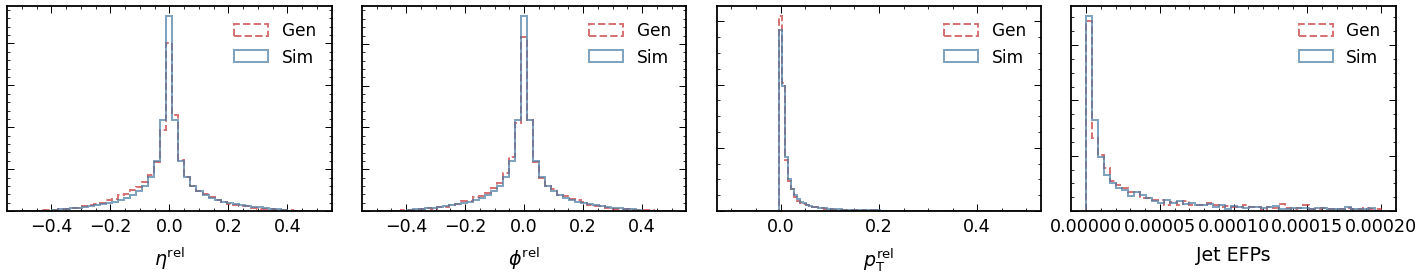

In [36]:
fig = plt.figure(figsize=(20, 4))
gs = GridSpec(1, 4)

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.5, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

#####

ax = fig.add_subplot(gs[3])

bins_efps = np.linspace(0, 2e-4, 50)
plt.hist(np.concatenate(efps_eval), bins=bins_efps, density=True, histtype='step', lw=2, ls='--', alpha=0.7, label='Gen');
plt.hist(np.concatenate(efps_sim), bins=bins_efps, density=True, histtype='step', lw=2, alpha=0.7, label='Sim');

ax.set_xlabel("Jet EFPs")
ax.get_yaxis().set_ticklabels([]);
ax.legend()

plt.savefig("plots/summaries.png", bbox_inches='tight')
plt.tight_layout()